In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn import preprocessing

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('car_price_prediction.csv')
# Insignificant Data
data = data.drop(columns=['ID','Color'])
    
testing = data[1:int(len(data)*0.20)]
training = data[int(len(data)*0.20):]
training

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Turbo,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Left Wheel,Airbags
2142,19601,690,FORD,Escape,2016,Jeep,1,Petrol,1.5,1,108295,4,Automatic,Front,4,1,10
2143,12231,530,NISSAN,Juke,2013,Jeep,1,Petrol,1.6,0,110531,4,Automatic,4x4,4,1,0
2144,13799,1017,HYUNDAI,Sonata,2017,Sedan,1,LPG,2.0,0,388986,4,Automatic,Front,4,1,4
2145,18817,308,TOYOTA,Prius,2014,Hatchback,0,Hybrid,1.8,0,145000,4,Automatic,Front,4,1,10
2146,34406,777,HYUNDAI,H1,2014,Minivan,1,Diesel,2.5,0,125445,4,Automatic,Front,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10708,29793,1053,MERCEDES-BENZ,E 350,2014,Sedan,1,Diesel,3.5,0,219030,6,Automatic,4x4,4,1,12
10709,5802,1055,MERCEDES-BENZ,E 350,2013,Sedan,1,Diesel,3.5,0,107800,6,Automatic,Rear,4,1,12
10710,15681,831,HYUNDAI,Sonata,2011,Sedan,1,Petrol,2.4,0,161600,4,Tiptronic,Front,4,1,8
10711,26108,836,HYUNDAI,Tucson,2010,Jeep,1,Diesel,2.0,0,116365,4,Automatic,Front,4,1,4


In [4]:
# Percentage of occurance
for column in data:
    if (column in ["Price", "Levy", "Prod. year", "Mileage"]):
        print(f"\"{column}\" ranges from {data[column].min()} to {data[column].max()}\n\n")
    else:
        values = data[column].value_counts()/len(data)*100
        print(f"Percentage of values in \"{column}\":\n\n{values}\n\n")

"Price" ranges from 1019 to 308906


"Levy" ranges from 87 to 7536


Percentage of values in "Manufacturer":

HYUNDAI          31.055727
TOYOTA           18.118174
CHEVROLET         8.176981
MERCEDES-BENZ     6.767479
LEXUS             5.105946
FORD              5.049939
HONDA             4.321852
SSANGYONG         4.107160
BMW               3.164380
KIA               2.800336
VOLKSWAGEN        2.146924
NISSAN            2.090918
SUBARU            0.998787
AUDI              0.952114
DAEWOO            0.840101
JEEP              0.728087
OPEL              0.644077
MAZDA             0.522729
MITSUBISHI        0.476057
DODGE             0.354709
FIAT              0.261365
JAGUAR            0.168020
PORSCHE           0.149351
LAND ROVER        0.149351
MINI              0.130682
SUZUKI            0.121348
GMC               0.112013
BUICK             0.102679
CHRYSLER          0.093345
ACURA             0.093345
RENAULT           0.074676
CADILLAC          0.046672
INFINITI          0.018669

In [5]:
# Make Encoder
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
enc.fit(training.select_dtypes(exclude=np.number).join(training['Prod. year']))

def prepare_data(dataframe):
    # Normalize Data
    scaler = preprocessing.MinMaxScaler()
    numeric_columns = dataframe.select_dtypes(include=np.number).columns.drop(["Price", "Prod. year"])

    # Encode values to boolean arrays
    input = scaler.fit_transform(dataframe[numeric_columns])

    input = np.append(input, enc.transform(dataframe.select_dtypes(exclude=np.number).join(dataframe['Prod. year'])).toarray(), axis=1)

    return TensorDataset(torch.tensor(input, dtype=torch.float64), torch.tensor(dataframe["Price"].to_numpy()))

# Make datasets and dataloaders
training_dataset = prepare_data(training)
training_dataloader = DataLoader(training_dataset, batch_size=128, shuffle=True)

testing_dataset = prepare_data(testing)
testing_dataloader = DataLoader(testing_dataset, batch_size=1282, shuffle=True)

In [6]:
class perceptron(nn.Module):
    def __init__(self):
        super(perceptron, self).__init__()
        # All columns are features except ID, Price, and Color. Price will be the result
        self.layer1 = nn.Linear(473, 128, dtype=torch.float64)
        self.layer2 = nn.Linear(128, 1, dtype=torch.float64)
    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        return x

In [7]:
if __name__ == "__main__":
    model = perceptron()
    loss = nn.L1Loss()
    opt = torch.optim.Adam(model.parameters(), lr=0.09)
    epochs = 100
    
    testing_losses = []
    training_losses = []
    
    for e in range(epochs):
        # Train Model
        training_loss = 0
        for batch in training_dataloader:
            X, y = batch
            out = model(X)
            
            l = loss(out.flatten(), y)

            training_loss += l

            l.backward()
            opt.step()
            opt.zero_grad()
        
        # Test Model
        testing_loss = 0
        for batch in testing_dataloader:
            X, y = batch
            out = model(X)

            l = loss(out.flatten(), y)

            testing_loss += l
            
        # Calculate average loss for epoch
        training_loss /= len(training_dataset)   
        training_losses.append(training_loss)
        testing_loss /= len(testing_dataset)
        testing_losses.append(testing_loss)
        
        # Epoch Results
        print("Epoch ", e+1, "/", epochs)
        print("Training loss: ", training_loss)
        print("Testing loss: ", testing_loss,end="\n\n")
    
    # To .csv
    
    output = pd.DataFrame({'Expected Cost': pd.Series(dtype='float'),
                   'Predicted Cost': pd.Series(dtype='float')})
    
    for batch in testing_dataloader:
        X, y = batch
        out = model(X)
        
        for i in range(len(X)):
            output.loc[len(output.index)] = [y.numpy()[i], out.detach().numpy()[i][0]]

    output.to_csv("out.csv")
    
    # Pearson correlation
    correlation = stats.pearsonr(output['Expected Cost'], output['Predicted Cost'])
    print(correlation)

Epoch  1 / 100
Training loss:  tensor(312.8584, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(242.1654, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  2 / 100
Training loss:  tensor(244.1110, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(223.7056, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  3 / 100
Training loss:  tensor(225.9901, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(212.7754, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  4 / 100
Training loss:  tensor(212.3350, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(206.7314, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  5 / 100
Training loss:  tensor(205.6201, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(203.3985, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  6 / 100
Training loss:  tensor(198.9247, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(197.9194, dtype=torch.float64,

Epoch  49 / 100
Training loss:  tensor(122.2589, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(204.0701, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  50 / 100
Training loss:  tensor(121.3037, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(211.5984, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  51 / 100
Training loss:  tensor(121.5342, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(211.4621, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  52 / 100
Training loss:  tensor(120.3554, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(206.4129, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  53 / 100
Training loss:  tensor(120.2655, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(217.1551, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  54 / 100
Training loss:  tensor(119.4393, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(226.2168, dtype=torch.fl

Epoch  97 / 100
Training loss:  tensor(104.2330, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(279.4543, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  98 / 100
Training loss:  tensor(103.3085, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(283.9597, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  99 / 100
Training loss:  tensor(103.2028, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(295.3900, dtype=torch.float64, grad_fn=<DivBackward0>)

Epoch  100 / 100
Training loss:  tensor(103.1649, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(290.5322, dtype=torch.float64, grad_fn=<DivBackward0>)

PearsonRResult(statistic=0.7637841821243216, pvalue=0.0)


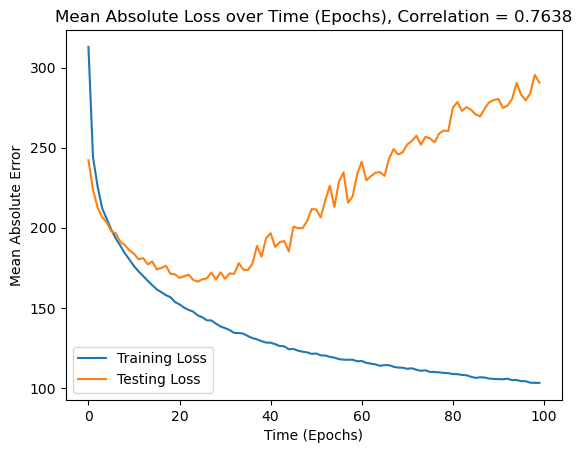

In [8]:
plt.plot(np.arange(epochs), [x.item() for x in training_losses], label="Training Loss")
plt.plot(np.arange(epochs), [x.item() for x in testing_losses], label="Testing Loss")

plt.title(f'Mean Absolute Loss over Time (Epochs), Correlation = {round(correlation[0],4)}')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Time (Epochs)')

plt.legend()
plt.show()